<a href="https://colab.research.google.com/github/berenkose664-blip/plakatanima/blob/main/Denetimli_%C3%B6%C4%9Frenme_final_proje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 18.1 MB/s eta 0:00:00


In [2]:
import kagglehub, os, shutil, torch, cv2, easyocr, re

from ultralytics import YOLO

from IPython.display import Image as IPImage, display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# =======================
# DATASET
# =======================

dataset = kagglehub.dataset_download('smaildurcan/turkish-license-plate-dataset')

dst = '/content/plaka_data_writable'


if os.path.exists(dst): shutil.rmtree(dst)

shutil.copytree(dataset, dst)

if os.path.exists(f'{dst}/label'): os.rename(f'{dst}/label', f'{dst}/labels')



with open('plaka_data.yaml','w') as f:

    f.write(

        "path: /content/plaka_data_writable/\n"

        "train: images\nval: images\n"

        "nc: 1\nnames: ['license_plate']\n"

    )

print("Dataset hazır.")

Using Colab cache for faster access to the 'turkish-license-plate-dataset' dataset.
Dataset hazır.


In [4]:
# =======================

# TRAIN

# =======================

print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "YOK")



model = YOLO('yolov8s.pt')

model.train(

    data='plaka_data.yaml',

    epochs=10,

    imgsz=640,

    batch=16,

    name='turkish_lp_detector_final_v3'

)

GPU: Tesla T4
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=plaka_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=turkish_lp_detector_final_v3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b192782fa40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

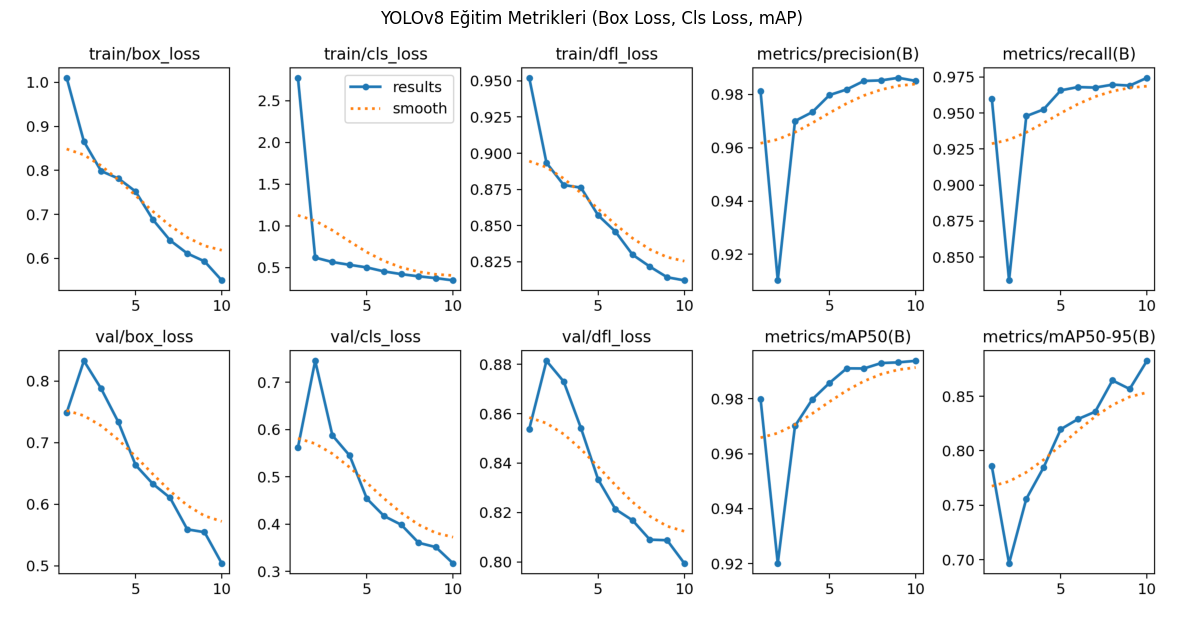

In [6]:
# ==========================================
# EĞİTİM SONUÇLARINI VE KAYIP GRAFİKLERİNİ GÖSTER (GÜNCEL)
# ==========================================
import os
import matplotlib.pyplot as plt
import cv2
import glob

# En son oluşturulan eğitim klasörünü otomatik bulur
# 'turkish_lp_detector_final_v3' ismini verdiğin için o klasöre odaklanır
base_path = '/content/runs/detect/turkish_lp_detector_final_v3'
results_path = os.path.join(base_path, 'results.png')

if os.path.exists(results_path):
    results_img = cv2.imread(results_path)
    results_img = cv2.cvtColor(results_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 10))
    plt.imshow(results_img)
    plt.title("YOLOv8 Eğitim Metrikleri (Box Loss, Cls Loss, mAP)")
    plt.axis('off')
    plt.show()
else:
    # Eğer yukarıdaki isim tutmazsa, 'runs' içindeki en son dosyayı bulmaya çalışır
    all_runs = glob.glob('/content/runs/detect/train*')
    if all_runs:
        latest_run = max(all_runs, key=os.path.getmtime)
        results_path = os.path.join(latest_run, 'results.png')

        if os.path.exists(results_path):
            results_img = cv2.imread(results_path)
            results_img = cv2.cvtColor(results_img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(15, 10))
            plt.imshow(results_img)
            plt.show()
        else:
            print("❌ results.png hala bulunamadı. Eğitim henüz tamamlanmamış olabilir.")
    else:
        print("❌ Hiçbir eğitim klasörü bulunamadı.")

In [7]:
# =======================

# VALIDATION

# =======================

best = '/content/runs/detect/turkish_lp_detector_final_v3/weights/best.pt'

detector = YOLO(best)



metrics = detector.val(data='plaka_data.yaml', imgsz=640, batch=16)



print("\n--- METRİKLER ---")

print(f"mAP50-95: {metrics.box.map}")

print(f"mAP50: {metrics.box.map50}")

print(f"Precision: {metrics.box.mp}")

print(f"Recall: {metrics.box.mr}")

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 671.6±262.5 MB/s, size: 3474.7 KB)
val: Scanning /content/plaka_data_writable/labels.cache... 1955 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1955/1955 2.9Mit/s 0.0s
train: /content/plaka_data_writable/images/1.jpg: corrupt JPEG restored and saved
train: /content/plaka_data_writable/images/105.jpg: corrupt JPEG restored and saved
train: /content/plaka_data_writable/images/125.jpg: corrupt JPEG restored and saved
train: /content/plaka_data_writable/images/126.jpg: corrupt JPEG restored and saved
train: /content/plaka_data_writable/images/13.jpg: corrupt JPEG restored and saved
train: /content/plaka_data_writable/images/134.jpg: corrupt JPEG restored and saved
train: /content/plaka_data_writable/images/140.jpg: corrupt JPEG restored and saved
train: /content/plaka_dat


image 1/1 /content/plaka_data_writable/images/1053.jpg: 480x640 1 license_plate, 79.8ms
Speed: 23.1ms preprocess, 79.8ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 640)


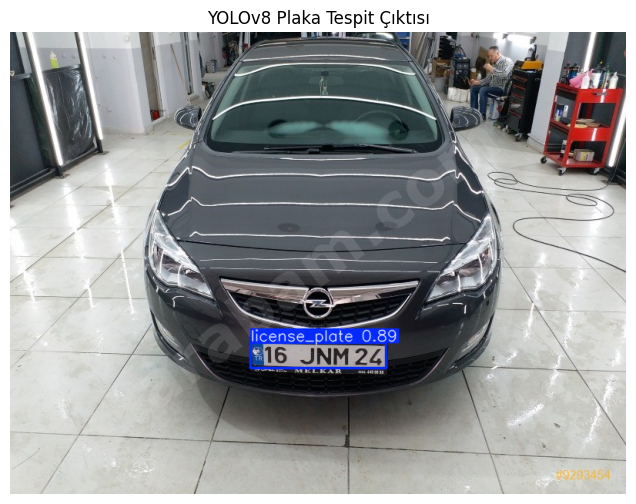

YOLO tespiti tamamlandı. Yukarıdaki görselde plaka kutu içine alınmıştır.


In [8]:
# ==========================================
# YOLO TESPİT GÖRSELLEŞTİRME
# ==========================================
import matplotlib.pyplot as plt

# Define img_path before use
IMG_DIR = f'{dst}/images'
img_name = sorted([f for f in os.listdir(IMG_DIR) if f.lower().endswith(('jpg','png'))])[61]
img_path = f"{IMG_DIR}/{img_name}"

# Tahmin yap
results = detector.predict(img_path, conf=0.4)

# Sonuçları görselleştir
for r in results:
    im_array = r.plot()  # YOLO'nun kendi çizim fonksiyonu (Bbox + Etiket)
    im_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB) # Renkleri düzelt

    plt.figure(figsize=(10, 6))
    plt.imshow(im_rgb)
    plt.title("YOLOv8 Plaka Tespit Çıktısı")
    plt.axis('off')
    plt.show()

print("YOLO tespiti tamamlandı. Yukarıdaki görselde plaka kutu içine alınmıştır.")

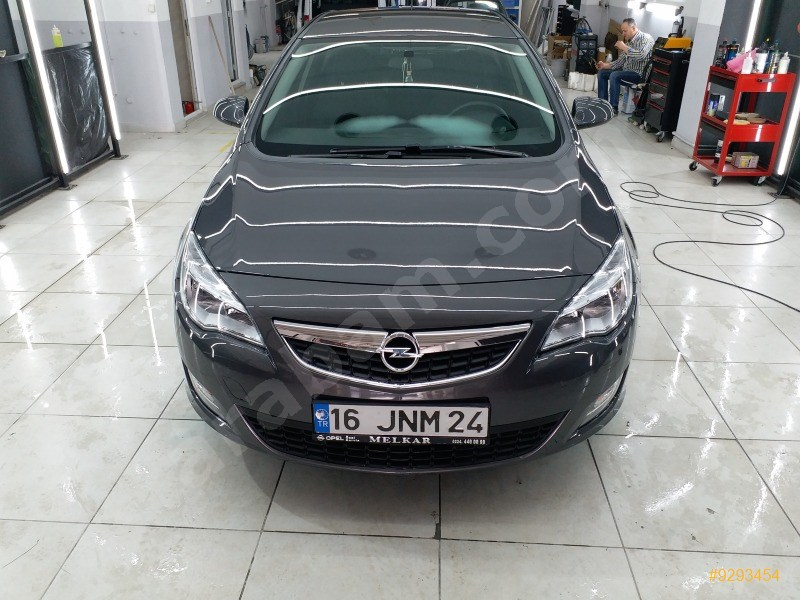


image 1/1 /content/plaka_data_writable/images/1053.jpg: 480x640 1 license_plate, 15.1ms
Speed: 5.7ms preprocess, 15.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


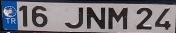

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [9]:
# =======================

# OCR (YOLO CROP + FIX)

# =======================

IMG_DIR = f'{dst}/images'

img_name = sorted([f for f in os.listdir(IMG_DIR) if f.lower().endswith(('jpg','png'))])[61]

img_path = f"{IMG_DIR}/{img_name}"



img = cv2.imread(img_path)

display(IPImage(filename=img_path))



res = detector(img_path, conf=0.4)[0]

if not res.boxes:

    raise Exception("❌ Plaka bulunamadı")



x1,y1,x2,y2 = map(int, res.boxes.xyxy[0])

plate = img[y1:y2, x1:x2]

display(IPImage(data=cv2.imencode('.jpg', plate)[1].tobytes()))



ocr = easyocr.Reader(['tr','en'])



g = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

g = cv2.resize(g, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

_, g = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [10]:
# ===== OCR + FORMAT FIX =====

raw = "".join(ocr.readtext(g, detail=0))

raw = re.sub(r'[^A-Z0-9]', '', raw.upper())



# TR varsa sil

if raw.startswith("TR"):

    raw = raw[2:]



# Doğru plaka formatını yakala

m = re.search(r'(0[1-9]|[1-7][0-9]|8[01])[A-Z]{1,3}[0-9]{2,4}', raw)

raw = m.group(0) if m else raw



fix = {'Z':'7','O':'0','A':'4','S':'5','B':'8'}

def smart(text):

    return (

        text[:2] +

        text[2:5] +

        "".join(fix.get(c, c) for c in text[5:])

    )



print("OCR Ham:", raw)

print("✅ Okunan Plaka:", smart(raw))

OCR Ham: 7H16JNM2G
✅ Okunan Plaka: 7H16JNM2G
